<a href="https://colab.research.google.com/github/atulkum/coding/blob/main/Atul_Kumar_C4AIScholars_takehome_challenge_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C4AI Scholars Program Takehome Challenge


### Background

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of three parts:

* Part One of the challenge requires identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
* Part Two of the challenge tests your ability to generate code for a specified problem. 
* Part Three of the challenge is an opportunity for you to attempt an optional challenge question that extends the original problem set. 


These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources. 

Good luck! If you have questions about the framing of the questions, please contact info@for.ai  


### How to Use and Submit this Document

* **Make a copy of this document** and **rename** it **Firstname_Lastname_C4AIScholarsChallenge**
* Once you’ve completed all tasks, **save and pin your revisions**
* **Submit a link** to your final document via the [Cohere For AI Scholars Program application](https://jobs.lever.co/cohere/?department=Cohere%20For%20AI). 



---



## Overview of Singular Value Decomposition

In this takehome, you will be working on a problem involving singular value decomposition. Singular Value Decomposition (SVD) exists for every rectangular matrix. The nice thing about SVD is that the original matrix can be expressed as the sum of outer products of left and singular vectors scaled by the corresponding singular values. Formally:

> Let 𝛢 be a rectangular matrix of dimensions 𝑚𝘹𝑛, then the SVD of the matrix A is given by $ A = U𝛴V^T$ where $U$ is an orthogonal matrix of shape mxm containing the left singular vectors, $V$ is an orthogonal matrix of shape nxn containing the right singular vectors and $𝛴$ is a diagonal matrix containing the singular values of $A$. This formulation of SVD can be re-expressed as \begin{align} A = \sum_{i=1}^{r} s_i. u_i v_i^T \end{align} where $r = \text{min}(m,n)$ represents the rank of the matrix, $s_i$ is the $i$th singular value and $u_i v_i^T$ is the outer product of the $i$th left and right singular vectors. 

<!-- \begin{align}
A = \sum_{i=1}^{\text{min}(m,n)} s_i. u_i v_i^T
\end{align}
\begin{align} -->

> The singular values $𝛴$ are decreasing in order. So, each outer product is scaled by a smaller value as we compute each term in the sum above. This gives us an opportunity to approximate $A$ using only the sum of the first $k$ outer products where $k < \text{min}(m,n)$ $-$ this effectively means that we are zero-ing out some of the singular values by assuming that the contribution to the sum is negligible. This is called low-rank approximation.

If you aren't familiar with singular value decomposition, or the above feels rusty, don't worry. Take a moment to brush up your knowledge using any of the following resources:
* [stanford lecture notes on low rank approximations](https://web.stanford.edu/class/cs168/l/l9.pdf)
* [youtube series of short and beginner friendly lectures](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv)



## Check for understanding (3 points)

#### Q1: What are some real world applications of low rank approximations?


#### Answer:
Data Compression

De-noising the data set

Matrix completion 



#### Q2: What are the benefits of compressing a deep neural network? How would you measure the benefits of compression?


#### Answer:
benefits: 

reduce number of parameters

less sparse matrix operation, increase throughput of GPU computation

fast inference

How would you measure the benefits of compression?

accuracy @ compressed %




#### Q3: In this takehome, we will consider how singular value decomposition can be used to compress a deep neural network. Compared to other compression methods used for deep neural networks such as pruning, quantization, or efficient architectures, what are the relative merits/demerits of low rank approximations? Choose one or two alternative compression methods and compare with singular value decomposition.

#### Answer:
quantization vs low rank approximations
1) quantization can not remove sparcity in the network but low rank approximations remove sparcity.
2) quantization is easy to implment low rank approximations need more computation.
3) If all the variance is explained by selected rank in low rank approximation then we don't lose much accuracy, but quantization reduce the range of weight values and hence affect accuracy.



---



### Imports

In [2]:
!pip install dm-haiku optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 350 kB 13.2 MB/s 
     |████████████████████████████████| 145 kB 59.5 MB/s 
     |████████████████████████████████| 85 kB 2.8 MB/s 


In [4]:
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math

Batch = Tuple[np.ndarray, np.ndarray]



---




## Coding Challenge Part I : Debugging Challenge (10 Points)


We are now going to explore using SVD to compute low rank approximations of the parameters of a small deep neural network. You are using a very simple toy model as a first baseline. Section 3 will give you the chance to improve baseline accuracy beyond this very simple model -- this is just a toy setting to first explore low rank approximations.

The first part of this challenge is primarily a debugging challenge. It will require removing bugs in order to train a very simple network. We have introduced several bugs -- some are subtle and will not break your code but will degrade final performance. These subtle bugs are introduced to understand your grasp of fundamental machine learning principles. There are also more obvious bugs designed to break your code. 

* [**4 points**] Your goal is to get the code working. There are 4 bugs in the code, all 4 of these are subtle bugs which are designed to impair test accuracy but not break the code. You will get partial points for each of the 4 bugs you find. After finding all bugs, your test performance should be around 66-67% test accuracy. 

* [**2 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs. 

* [**4 points**] There are also two functions you will need to code up in this section -- we indicate where these code changes need to happen with TODO comments. 

* Do not alter the model architecture or the learning rate.


Useful tips:
* To iterate faster and avoid training for 10000 steps each time you want to test whether you have found all the bugs, a good sign you have caught the bugs is wheter after 1000/10000 steps your accuracy >40%.
* The colab difftool is useful to track what code you have changed during the debugging challenge (incase you need to revert code). You can access this via tools > diff notebooks.

In [8]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)


def net_fn(batch: Batch) -> jnp.ndarray:
    x = normalize(batch[0])

    # Do NOT alter the architecture definition below.
    net = hk.Sequential([
        hk.Conv2D(output_channels=6 * 3, kernel_shape=(5, 5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
        jax.nn.relu,
        hk.Conv2D(output_channels=16 * 3, kernel_shape=(5, 5)),
        jax.nn.relu,
        hk.AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
        hk.Flatten(),
        hk.Linear(3000), jax.nn.relu,
        hk.Linear(2000), jax.nn.relu,
        hk.Linear(2000), jax.nn.relu,
        hk.Linear(1000), jax.nn.relu,
        hk.Linear(10),
    ])
    return net(x)


def load_dataset(
        split: str,
        *,
        is_training: bool,
        batch_size: int,
) -> Iterator[tuple]:
    """Loads the dataset as a generator of batches."""
    ds = tfds.load('cifar10', split=split, as_supervised=True).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))


@jax.jit
def compute_loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    x, y = batch
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(y, 10)

    # TODO: add code below to compute the l2_loss variable
    l2_loss = 0.5 * sum(
        jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    # BUG 1: "softmax_xent - (1e-4 * l2_loss)"
    # should be "softmax_xent + (1e-4 * l2_loss)"
    return softmax_xent + 1e-4 * l2_loss


@jax.jit
def compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
    """Evaluation metric (classification accuracy)."""
    predictions = net.apply(params, batch)

    # TODO: add code below to compute the accuracy over the batch.
    accuracy = jnp.mean(jnp.argmax(predictions, axis=-1) == batch[1])
    return accuracy


@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """Update the weights using backpropagation with Adam optimizer."""
  grads = jax.grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """
   maintain avg_params, the exponential moving average of the "live" params.
   avg_params is used only for evaluation 
  """
  return optax.incremental_update(params, avg_params, step_size=0.001)


def normalize(images):
  """
  Normalize the input RGB image.
  """
  mean = np.asarray(CIFAR10_MEAN)
  std = np.asarray(CIFAR10_STD)
  #BUG 2: datatype should be jnp.float32
  x = images.astype(jnp.float32) / 255.
  #BUG 3: "x /- mean" should be "x -= mean"
  x -= mean
  x /= std

  return x

### Training

In [9]:
net = hk.without_apply_rng(hk.transform(net_fn))

# Do not change learning rate
opt = optax.adam(1e-3)
#BUG 4: train should have "train[0%:80%]" split 
train = load_dataset("train[0%:80%]" , is_training=True, batch_size=1000)
validation = load_dataset("train[80%:]", is_training=False, batch_size=10000)
test = load_dataset("test", is_training=False, batch_size=10000)

params = avg_params = net.init(jax.random.PRNGKey(42), next(train))
opt_state = opt.init(params)

# Do not alter the number of steps
for step in range(10001):
  if step % 1000 == 0:
    val_accuracy = compute_accuracy(avg_params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))
    val_accuracy, test_accuracy = jax.device_get(
        (val_accuracy, test_accuracy))
    print(f"[Step {step}] Validation / Test accuracy: "
          f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

  params, opt_state = update(params, opt_state, next(train))
  avg_params = ema_update(params, avg_params)

[Step 0] Validation / Test accuracy: 0.101 / 0.103.
[Step 1000] Validation / Test accuracy: 0.473 / 0.483.
[Step 2000] Validation / Test accuracy: 0.603 / 0.614.
[Step 3000] Validation / Test accuracy: 0.616 / 0.626.
[Step 4000] Validation / Test accuracy: 0.621 / 0.630.
[Step 5000] Validation / Test accuracy: 0.623 / 0.628.
[Step 6000] Validation / Test accuracy: 0.625 / 0.625.
[Step 7000] Validation / Test accuracy: 0.626 / 0.623.
[Step 8000] Validation / Test accuracy: 0.628 / 0.626.
[Step 9000] Validation / Test accuracy: 0.624 / 0.625.
[Step 10000] Validation / Test accuracy: 0.625 / 0.628.




---



## Coding Challenge Part 2: Compression through Low Rank Approximation (8 points)

In this section, you will add code to compute the low rank approximation and to compute evaluation metrics. We will evaluate whether the low rank approximation allows for speed up in inference time. We define inference time as the average time to compute the prediction for all examples in the test set.

* [**4 points**] You will need to add code to define both the compute_eval_metrics and rank_approximated weight function. 
* [**4 points**] Q4 and Q5 are worth 2 points each.

In [10]:
def compute_eval_metrics(params, batch, n_samples):
# TODO: add code to compute the time for inference.
  duration_list = []
  accuracy_list = []
  for _ in range(n_samples):
    start = time.perf_counter()
    # TODO: add code to correctly compute the accuracy on a given batch.
    acc = compute_accuracy(params, batch)
    duration = time.perf_counter() - start
    duration_list.append(duration)
    accuracy_list.append(acc)

  return accuracy_list, duration_list

In [11]:
def rank_approximated_weight(weight: jnp.ndarray, rank_fraction: float):
  # TODO: replace the code below with code to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
  size = min(weight.shape[0], weight.shape[1])
  k = int(size*rank_fraction)
  U, S, V = jnp.linalg.svd(weight, full_matrices=False)
  u = U[:, :k] @ jnp.diag(S[:k])
  v = V[:k, :]  
  return u, v

### Evaluations at different ranks

The code below first replaces the weights with the low rank factorizations at different rank fractions. For each modified net, we compute the new eval accuracy. Firstly, add code for the rank_approximated_weight and add code to correctly compute the time for inference (the duration).

In [12]:
rank_truncated_params = deepcopy(params)
ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):

  print(f"Evaluating the model at {rank_fraction}")
  for layer in params.keys():
    if 'conv' in layer:
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    rank_truncated_params[layer]['w'] = u@v

  test_batch = next(test)
  # we compute metrics over 50 samples to reduce noise in the measurement.
  n_samples = 50
  # TODO: complete coding the compute_eval_metrics function to compute latency 50 seperate times given the batch passed to compute_eval_metrics. Return the average across all latencies you store.
  test_accuracy, latency = compute_eval_metrics(rank_truncated_params, next(test), n_samples)
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(latency):.4f}.")
  ranks_and_times.append((rank_fraction, np.mean(latency)))

Evaluating the model at 1.0
Rank Fraction / Test accuracy: 1.00 / 0.595.
Rank Fraction / Duration: 1.00 / 0.0889.
Evaluating the model at 0.9
Rank Fraction / Test accuracy: 0.90 / 0.596.
Rank Fraction / Duration: 0.90 / 0.0889.
Evaluating the model at 0.8
Rank Fraction / Test accuracy: 0.80 / 0.596.
Rank Fraction / Duration: 0.80 / 0.0893.
Evaluating the model at 0.7000000000000001
Rank Fraction / Test accuracy: 0.70 / 0.592.
Rank Fraction / Duration: 0.70 / 0.0900.
Evaluating the model at 0.6000000000000001
Rank Fraction / Test accuracy: 0.60 / 0.592.
Rank Fraction / Duration: 0.60 / 0.0915.
Evaluating the model at 0.5000000000000001
Rank Fraction / Test accuracy: 0.50 / 0.570.
Rank Fraction / Duration: 0.50 / 0.0909.
Evaluating the model at 0.40000000000000013
Rank Fraction / Test accuracy: 0.40 / 0.549.
Rank Fraction / Duration: 0.40 / 0.0902.
Evaluating the model at 0.30000000000000016
Rank Fraction / Test accuracy: 0.30 / 0.529.
Rank Fraction / Duration: 0.30 / 0.0909.
Evaluating 

### Q4: What do you observe as the relationship between rank fraction and test accuracy?

Plot this relationship showing accuracy (y-axis) vs rank percentage of the matrix (x-axis). You should use the ranks_and_accuracies list computed above.

Answer:

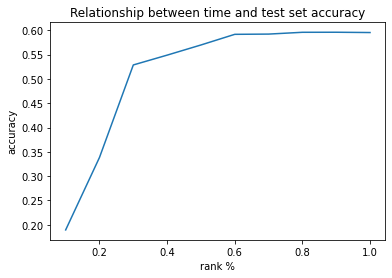

In [13]:
## TODO: add your code below to plot the relationship between time and test set accuracy
x = []
y = []
for r, a in ranks_and_accuracies:
  y.append(a)
  x.append(r)
plt.plot(x, y)
plt.title("Relationship between time and test set accuracy")
plt.xlabel("rank %")
plt.ylabel("accuracy")
plt.show()

### Q5: Does replacing the weight matrix with the low factor matrix result in latency speed ups?

Plot the relationship of time (y-axis) vs rank percentage (x-axis). To do so add code to compute the ranks_and_times list.

Answer:

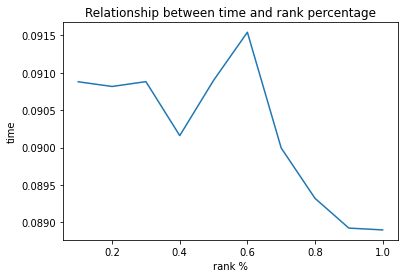

In [14]:
## TODO: add your code below to plot the relationship between time and rank percentage
x = []
y = []
for r, t in ranks_and_times:
  y.append(t)
  x.append(r)
plt.plot(x, y)
plt.title("Relationship between time and rank percentage")
plt.xlabel("rank %")
plt.ylabel("time")
plt.show()

## Coding Challenge Part 3: Perform evaluations on the dataset in factorized space. (4 points)

In this section, you will perform evaluations on the dataset in factorized space.

* [**4 points**] 2 pts for question 6 and question 7.

In [15]:
def low_rank_net_fn(batch: Batch, rank: float) -> jnp.ndarray:
  
  x = normalize(batch[0])
  total_input_dim = np.prod(x.shape[1:])

  # Do not alter the architecture code.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(int(rank * min(total_input_dim, 3000)), with_bias=False),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,      
      hk.Linear(int(rank * 1000), with_bias=False), 
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(int(rank * 10), with_bias=False),
      hk.Linear(10),
  ])
  return net(x)

In [16]:
vanilla_to_low_rank_map = {
    'conv2_d': 'conv2_d',
    'conv2_d_1': 'conv2_d_1',
    'linear': ['linear', 'linear_1'],
    'linear_1': ['linear_2', 'linear_3'],
    'linear_2': ['linear_4', 'linear_5'],
    'linear_3': ['linear_6', 'linear_7'],
    'linear_4': ['linear_8', 'linear_9']
}


ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):
  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial)) 
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at" f"{rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']
  
  # TODO: modify the compute_eval_metrics function below to compute the time taken for inference.
  test_accuracy, duration = compute_eval_metrics(low_rank_params, next(test), 50)
  ranks_and_times.append((rank_fraction, np.mean(duration)))
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(duration):.4f}.")

Evaluating the model at1.00
Rank Fraction / Test accuracy: 1.00 / 0.595.
Rank Fraction / Duration: 1.00 / 0.2886.
Evaluating the model at0.90
Rank Fraction / Test accuracy: 0.90 / 0.596.
Rank Fraction / Duration: 0.90 / 0.2841.
Evaluating the model at0.80
Rank Fraction / Test accuracy: 0.80 / 0.596.
Rank Fraction / Duration: 0.80 / 0.2571.
Evaluating the model at0.70
Rank Fraction / Test accuracy: 0.70 / 0.592.
Rank Fraction / Duration: 0.70 / 0.2371.
Evaluating the model at0.60
Rank Fraction / Test accuracy: 0.60 / 0.592.
Rank Fraction / Duration: 0.60 / 0.2173.
Evaluating the model at0.50
Rank Fraction / Test accuracy: 0.50 / 0.570.
Rank Fraction / Duration: 0.50 / 0.1926.
Evaluating the model at0.40
Rank Fraction / Test accuracy: 0.40 / 0.549.
Rank Fraction / Duration: 0.40 / 0.1802.
Evaluating the model at0.30
Rank Fraction / Test accuracy: 0.30 / 0.529.
Rank Fraction / Duration: 0.30 / 0.1578.
Evaluating the model at0.20
Rank Fraction / Test accuracy: 0.20 / 0.338.
Rank Fraction /

### Q6: Plot a curve showing time vs rank percentage of the matrix 

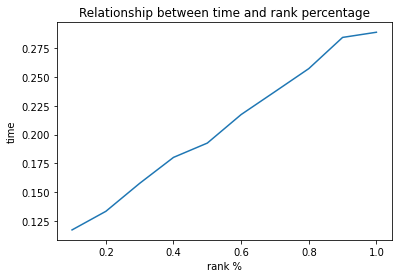

In [17]:
# TODO: add code to plot the relationship between time vs percentage rank of the matrix.
x = []
y = []
for r, t in ranks_and_times:
  y.append(t)
  x.append(r)
plt.plot(x, y)
plt.title("Relationship between time and rank percentage")
plt.xlabel("rank %")
plt.ylabel("time")
plt.show()

### Q7: What do you observe between time and the percentage rank of the matrix.

### Put your answer here:

Time is increasing almost linearly with rank %



---



## Coding Challenge Part 4: Take this Further (10 bonus points)

This part of the challenge is designed to be open ended. If you wanted to show some more skills, here is your chance to shine. We include two options below -- **only do one of the options**:

**Option 1:** Implement a change that isn't SVD but minimizes inference latency while preserving accuracy. Can you outperform SVD? 



**Option 2:** Improve the quality of code for this takehome. Pretend you are reviewing a peer and add comments to cells with suggestions of how to improve the code quality. Try and make your comments action orientated and precise. 


**For Option 1, DO NOT alter the previous code sections, instead add any new code below. You should not need to add new code for Option 2, instead just add comments to cells.**


In [ ]:
# TODO: add code for option 1 here

## You have made it to the end of the challenge!

Before you submit your completed challenge document, please make sure to **save and pin your revisions** before submitting a link to your submission via the [Cohere For AI Scholars Program Application.](https://jobs.lever.co/cohere/) 